## CONVOLUTION NEURAL NETWORKS FOR BREAST CANCER DIAGNOSIS
#### By Mahamat Azibert ABDELWAHAB

### Import all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras

from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16, EfficientNetB1
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import keras.backend as K
from keras import regularizers
from keras.layers import InputLayer, GlobalAveragePooling2D
from keras import optimizers

from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

from matplotlib.image import imread
import cv2 

from keras.applications.resnet import ResNet50


# My CNN Library
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils

from dense import Dense as dense
from convolutional import Convolutional
from reshape import Reshape
from activations import Sigmoid, Relu, Softmax
from losses import binary_cross_entropy, binary_cross_entropy_prime
from network import train, predict, fit
from pooling import Pooling
from model import Model
from dropout import Dropout as dropout

import warnings

warnings.filterwarnings("ignore")

# Images preprocessing

In [2]:
# All the images patches
imagePatches = glob('../Data/IDC/**/*.png', recursive=True)

class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

# Extract patches for Benign (0) and Malignant (1)
for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

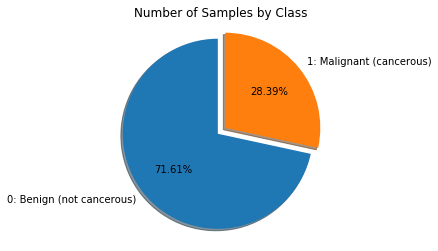

In [3]:
# Pie chart (Number of Samples For Each Class)
labels = "0: Benign (not cancerous)", "1: Malignant (cancerous)"
result = [len(class0), len(class1)]
total = result[0] + result[1]
sizes = [result[0]/total, result[1]/total]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=90)

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Number of Samples by Class")
plt.show()

In [4]:
# Function to read the images as arrays
def get_image_arrays(data, label, img_size = 50, bgr=True):
    
    img_arrays = []
    
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            
            if bgr==False:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
            img_sized = cv2.resize(img, (img_size,img_size), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
            
    return img_arrays

In [5]:
# Extract the same number of Malignant and Benign file patches
# to handle the unbalancing data problem
number_of_malignant = len(class1)
#number_of_malignant = int(number_of_malignant*0.2)
sampled_class0 = random.sample(class0, number_of_malignant)
sampled_class1 = random.sample(class1, number_of_malignant)

In [6]:
# Data preprocessing and split
def pre_processing(img_size=50, bgr = True):
    # Read the images
    class0_array = get_image_arrays(sampled_class0, 0, img_size, bgr)
    class1_array = get_image_arrays(sampled_class1, 1, img_size, bgr)

    # Combine and shuffle the data
    combined_data = np.concatenate((class0_array, class1_array))
    random.seed(41)
    random.shuffle(combined_data)
    
    # Extract Features and Target
    X = []
    y = []

    for features,label in combined_data:
        X.append(features)
        y.append(label)
    
    if bgr:
        X = np.array(X).reshape(-1, img_size, img_size, 3)
    else:
        X = np.array(X).reshape(-1, img_size, img_size, 1)
    
#     if bgr==False:
#         X = np.array(X).reshape(-1, img_size, img_size, 1)
    
    # set aside 20% of train and test data for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y,
        test_size=0.2, shuffle = True, random_state = 8)

    # Use the same function above for the validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
        test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
    
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    y_val = to_categorical(y_val)

#     # Normalize the data
#     X_train = X_train / 255.0
#     X_test = X_test / 255.0
#     X_val = X_val / 255.0
    
    X_train, X_test, X_val = X_train - np.mean(X_train), X_test - np.mean(X_test), X_val - np.mean(X_val)
    X_train, X_test, X_val = X_train / np.std(X_train), X_test / np.std(X_test), X_val / np.std(X_val)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [7]:
def describe_data_shape():
    print("X_train shape: {}".format(X_train.shape))
    print("X_test shape: {}".format(X_test.shape))
    print("y_train shape: {}".format(y_train.shape))
    print("y_test shape: {}".format(y_test.shape))
    print("X_val shape: {}".format(X_val.shape))
    print("y val shape: {}".format(y_val.shape))

In [8]:
def plot_confusion_matrix(model, X_test, y_test):
    Y_pred = model.predict(X_test)
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(y_test,axis = 1) 

    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

    f,ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(confusion_mtx, annot=True,cmap="OrRd",linecolor="black", fmt= '.1f',ax=ax, xticklabels=['False', 'True'],yticklabels=['False', 'True'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [9]:
def report(model, X_test, y_test):
    Y_pred = model.predict(X_test)
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(y_test,axis = 1) 
    
    print(classification_report(Y_true, Y_pred_classes))

In [10]:
def calc_accuracy_model(model, test_set):
    return print(f'''The model validation accuracy is: 
    {np.equal(np.argmax(model.forward(test_set, inference=True), axis=1), y_test).sum() * 100.0 / test_set.shape[0]:.2f}%''')

In [11]:
def Display_prediction_results(network, X, Y, set_title='Test'):
    
    Y_pred_classes = []
    Y_true = []
    
    for x, y in zip(X, Y):
        output = predict(network, x)
        Y_pred_classes.append(np.argmax(output))
        Y_true.append(np.argmax(y))
        
    Y_pred_classes = np.array(Y_pred_classes) 
    Y_true = np.array(Y_true)
    
    acc = np.equal(Y_pred_classes, Y_true).sum() * 100.0 / Y_true.shape[0]
    
    print(f'{set_title} accuracy: {acc}')
    
    
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

    f,ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(confusion_mtx, annot=True,cmap="OrRd",linecolor="black", fmt= '.1f',ax=ax, xticklabels=['False', 'True'],yticklabels=['False', 'True'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# CNN FROM SCRATCH

In [12]:
def plot_accuracy_loss_CNN(hist, title_fig = 'CNN Performance with ReLU'):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    t = f.suptitle(title_fig, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    n = len(hist['Train Acc'])

    epoch_list = list(range(1,n+1))
    ax1.plot(epoch_list, hist['Train Acc'], label='Train Accuracy')
    ax1.plot(epoch_list, hist['Val Acc'], label='Validation Accuracy')

    ax1.set_xticks(np.arange(0, n+1,5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, hist['Train Err'], label='Train Loss')
    ax2.plot(epoch_list, hist['Val Err'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, n+1,5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

In [13]:
IMG_SIZE = 32

X_train, X_test, X_val, y_train, y_test, y_val = pre_processing(img_size=IMG_SIZE, bgr = False)

X_train, X_test = X_train.reshape(-1, 1, IMG_SIZE, IMG_SIZE), X_test.reshape(-1, 1, IMG_SIZE, IMG_SIZE)
X_val = X_val.reshape(-1, 1, IMG_SIZE, IMG_SIZE)

describe_data_shape()

X_train shape: (94542, 1, 32, 32)
X_test shape: (31515, 1, 32, 32)
y_train shape: (94542, 2)
y_test shape: (31515, 2)
X_val shape: (31515, 1, 32, 32)
y val shape: (31515, 2)


In [14]:
y_train = y_train.reshape(len(y_train), 2, 1)
y_test = y_test.reshape(len(y_test), 2, 1)
y_val = y_val.reshape(len(y_val), 2, 1)

### CNN model with sigmoid activation

In [15]:
network1 = [
    Convolutional((1, 32, 32), 3, 3),
    Sigmoid(),
    Convolutional((3, 30, 30), 3, 3),
    Sigmoid(),
    Convolutional((3, 28, 28), 3, 3),
    Sigmoid(),
    Reshape((3, 26, 26), (3 * 26 * 26, 1)),
    dense(3 * 26 * 26, 512),
    Sigmoid(),
    dense(512, 128),
    Sigmoid(),
    dense(128, 2),
    Sigmoid()
]

In [16]:
# train
hist1 = train(
    network1,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    X_train,
    y_train,
    X_val,
    y_val,
    epochs=20,
    learning_rate=0.01
)

  0%|          | 0/94542 [00:00<?, ?it/s]

Epoch : 1/20


100%|██████████| 94542/94542 [23:42<00:00, 66.48it/s]


	Training: 	Acc:84.17528717395443, 	error: 0.3720739754874374


  0%|          | 9/94542 [00:00<19:16, 81.75it/s]

	Validation: 	Acc:83.5411708710138, 	error: 0.36894738513077274
Epoch : 2/20


100%|██████████| 94542/94542 [23:20<00:00, 67.49it/s]


	Training: 	Acc:84.19538406210997, 	error: 0.36335898533857625


  0%|          | 5/94542 [00:00<33:50, 46.55it/s]

	Validation: 	Acc:83.31588132635252, 	error: 0.3688812881600876
Epoch : 3/20


100%|██████████| 94542/94542 [22:50<00:00, 69.00it/s]


	Training: 	Acc:84.21336548835438, 	error: 0.36157042171290377


  0%|          | 9/94542 [00:00<19:19, 81.53it/s]

	Validation: 	Acc:82.88116769792163, 	error: 0.3695667438980841
Epoch : 4/20


100%|██████████| 94542/94542 [22:46<00:00, 69.17it/s]


	Training: 	Acc:84.20701910262106, 	error: 0.3604345129325301


  0%|          | 7/94542 [00:00<23:01, 68.43it/s]

	Validation: 	Acc:83.62684435982865, 	error: 0.36428393539285764
Epoch : 5/20


100%|██████████| 94542/94542 [22:50<00:00, 68.97it/s]


	Training: 	Acc:84.26625203613209, 	error: 0.3605129431953349


  0%|          | 6/94542 [00:00<26:23, 59.68it/s]

	Validation: 	Acc:83.88069173409488, 	error: 0.3634106707328196
Epoch : 6/20


100%|██████████| 94542/94542 [22:51<00:00, 68.94it/s]


	Training: 	Acc:84.28106026950985, 	error: 0.3591291395472942


  0%|          | 5/94542 [00:00<34:30, 45.66it/s]

	Validation: 	Acc:83.58876725368872, 	error: 0.36261512640991156
Epoch : 7/20


100%|██████████| 94542/94542 [23:10<00:00, 67.98it/s]


	Training: 	Acc:84.28846438619873, 	error: 0.35827286577435646


  0%|          | 5/94542 [00:00<33:38, 46.85it/s]

	Validation: 	Acc:83.83626844359829, 	error: 0.36253292879638443
Epoch : 8/20


100%|██████████| 94542/94542 [22:43<00:00, 69.34it/s]


	Training: 	Acc:84.23769330033213, 	error: 0.357626024961311


  0%|          | 5/94542 [00:00<33:59, 46.36it/s]

	Validation: 	Acc:83.46184356655561, 	error: 0.36355703527867983
Epoch : 9/20


100%|██████████| 94542/94542 [22:56<00:00, 68.67it/s]


	Training: 	Acc:84.32654270059868, 	error: 0.35736819806799774


  0%|          | 6/94542 [00:00<28:12, 55.86it/s]

	Validation: 	Acc:84.28050134856417, 	error: 0.3612630880343621
Epoch : 10/20


100%|██████████| 94542/94542 [21:11<00:00, 74.33it/s] 


	Training: 	Acc:84.33817774110977, 	error: 0.3566751973094763


  0%|          | 7/94542 [00:00<23:35, 66.78it/s]

	Validation: 	Acc:84.17578930667936, 	error: 0.36392678665612055
Epoch : 11/20


100%|██████████| 94542/94542 [22:48<00:00, 69.07it/s]


	Training: 	Acc:84.3350045482431, 	error: 0.3560820130543874


  0%|          | 5/94542 [00:00<35:30, 44.37it/s]

	Validation: 	Acc:84.01713469776297, 	error: 0.3642195353851132
Epoch : 12/20


100%|██████████| 94542/94542 [22:33<00:00, 69.87it/s]


	Training: 	Acc:84.28317573142095, 	error: 0.35619903688310406


  0%|          | 7/94542 [00:00<22:58, 68.56it/s]

	Validation: 	Acc:84.01713469776297, 	error: 0.3619863070196377
Epoch : 13/20


100%|██████████| 94542/94542 [22:58<00:00, 68.56it/s]


	Training: 	Acc:84.29057984810983, 	error: 0.3556512634932908


  0%|          | 5/94542 [00:00<33:06, 47.58it/s]

	Validation: 	Acc:84.35982865302238, 	error: 0.36021905517651487
Epoch : 14/20


100%|██████████| 94542/94542 [22:36<00:00, 69.68it/s]


	Training: 	Acc:84.29057984810983, 	error: 0.35546780945642203


  0%|          | 8/94542 [00:00<22:02, 71.50it/s]

	Validation: 	Acc:83.62684435982865, 	error: 0.3631553222633598
Epoch : 15/20


100%|██████████| 94542/94542 [22:44<00:00, 69.30it/s]


	Training: 	Acc:84.33923547206533, 	error: 0.35538719790926193


  0%|          | 7/94542 [00:00<23:53, 65.93it/s]

	Validation: 	Acc:84.23290496588926, 	error: 0.3606515658612492
Epoch : 16/20


100%|██████████| 94542/94542 [22:42<00:00, 69.41it/s]


	Training: 	Acc:84.35615916735419, 	error: 0.35442347231652244


  0%|          | 8/94542 [00:00<21:14, 74.19it/s]

	Validation: 	Acc:84.20117404410598, 	error: 0.36034589982380877
Epoch : 17/20


100%|██████████| 94542/94542 [22:58<00:00, 68.59it/s]


	Training: 	Acc:84.31067673626536, 	error: 0.3540298728552837


  0%|          | 8/94542 [00:00<20:01, 78.67it/s]

	Validation: 	Acc:83.96636522290973, 	error: 0.36287677563882326
Epoch : 18/20


100%|██████████| 94542/94542 [17:44<00:00, 88.78it/s] 


	Training: 	Acc:84.36567874595418, 	error: 0.35356871572589044


  0%|          | 12/94542 [00:00<13:16, 118.75it/s]

	Validation: 	Acc:84.23607805806759, 	error: 0.36250328725460723
Epoch : 19/20


100%|██████████| 94542/94542 [20:34<00:00, 76.61it/s] 


	Training: 	Acc:84.37837151742083, 	error: 0.35307957431025655


  0%|          | 7/94542 [00:00<23:54, 65.92it/s]

	Validation: 	Acc:84.09646200222116, 	error: 0.36249666292914884
Epoch : 20/20


100%|██████████| 94542/94542 [22:45<00:00, 69.22it/s]


	Training: 	Acc:84.37519832455416, 	error: 0.3528646208433464
	Validation: 	Acc:83.98540377597969, 	error: 0.3638114796910004


,Epoch,Train Acc,Val Acc,Train Err,Val Err
0,1,84.175287,83.541171,0.372074,0.368947
1,2,84.195384,83.315881,0.363359,0.368881
2,3,84.213365,82.881168,0.361570,0.369567
3,4,84.207019,83.626844,0.360435,0.364284
4,5,84.266252,83.880692,0.360513,0.363411
5,6,84.281060,83.588767,0.359129,0.362615
6,7,84.288464,83.836268,0.358273,0.362533
7,8,84.237693,83.461844,0.357626,0.363557
8,9,84.326543,84.280501,0.357368,0.361263
9,10,84.338178,84.175789,0.356675,0.363927


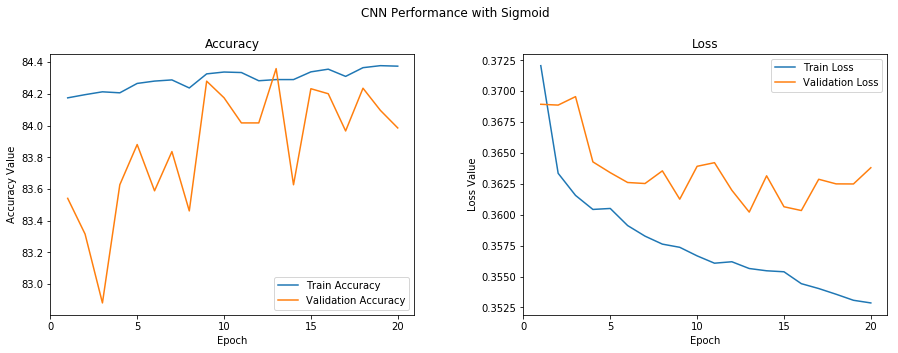

In [17]:
plot_accuracy_loss_CNN(hist1, title_fig = 'CNN Performance with Sigmoid')
hist1

Test accuracy: 83.80136442963668


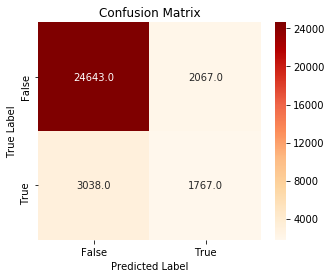

In [19]:
Display_prediction_results(network1, X_test, y_test)

### CNN model with relu activation

In [22]:
network2 = [
    Convolutional((1, 32, 32), 3, 5),
    Relu(),
    Convolutional((5, 30, 30), 3, 8),
    Relu(),
    Reshape((8, 28, 28), (8 * 28 * 28, 1)),
    dense(8 * 28 * 28, 64),
    Relu(),
    dense(64, 2),
    Softmax(),
]

In [23]:
# train
hist2 = train(
    network2,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    X_train,
    y_train,
    X_val,
    y_val,
    epochs=50,
    learning_rate=0.001
)

  0%|          | 1/94542 [00:00<3:25:37,  7.66it/s]

Epoch : 1/50


100%|██████████| 94542/94542 [32:24<00:00, 48.61it/s] 


	Training: 	Acc:84.70732584459817, 	error: nan


  0%|          | 2/94542 [00:00<1:21:56, 19.23it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 2/50


100%|██████████| 94542/94542 [31:25<00:00, 50.14it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 3/94542 [00:00<59:46, 26.36it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 3/50


100%|██████████| 94542/94542 [29:47<00:00, 52.89it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 3/94542 [00:00<56:10, 28.05it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 4/50


100%|██████████| 94542/94542 [29:33<00:00, 53.32it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 2/94542 [00:00<1:26:24, 18.23it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 5/50


100%|██████████| 94542/94542 [29:05<00:00, 54.17it/s]


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 1/94542 [00:00<4:23:16,  5.98it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 6/50


100%|██████████| 94542/94542 [29:15<00:00, 53.87it/s]


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 1/94542 [00:00<2:43:42,  9.63it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 7/50


100%|██████████| 94542/94542 [29:34<00:00, 53.29it/s]


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 2/94542 [00:00<1:25:44, 18.38it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 8/50


100%|██████████| 94542/94542 [29:11<00:00, 53.99it/s]


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 2/94542 [00:00<1:30:01, 17.50it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 9/50


100%|██████████| 94542/94542 [29:14<00:00, 53.88it/s]


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 2/94542 [00:00<1:34:42, 16.64it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 10/50


100%|██████████| 94542/94542 [29:24<00:00, 53.58it/s]


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 3/94542 [00:00<1:00:47, 25.92it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 11/50


100%|██████████| 94542/94542 [24:05<00:00, 65.42it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 9/94542 [00:00<18:05, 87.08it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 12/50


100%|██████████| 94542/94542 [21:50<00:00, 72.16it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 3/94542 [00:00<1:12:15, 21.80it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 13/50


100%|██████████| 94542/94542 [21:21<00:00, 73.77it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 6/94542 [00:00<26:24, 59.66it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 14/50


100%|██████████| 94542/94542 [22:03<00:00, 71.44it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 5/94542 [00:00<32:32, 48.43it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 15/50


100%|██████████| 94542/94542 [21:17<00:00, 74.00it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 6/94542 [00:00<27:09, 58.01it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 16/50


100%|██████████| 94542/94542 [22:42<00:00, 69.37it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 6/94542 [00:00<27:39, 56.97it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 17/50


100%|██████████| 94542/94542 [21:58<00:00, 71.68it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 4/94542 [00:00<42:15, 37.28it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 18/50


100%|██████████| 94542/94542 [21:39<00:00, 72.74it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 3/94542 [00:00<54:09, 29.10it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 19/50


100%|██████████| 94542/94542 [22:30<00:00, 70.03it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 6/94542 [00:00<26:49, 58.73it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 20/50


100%|██████████| 94542/94542 [21:41<00:00, 72.64it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 6/94542 [00:00<28:12, 55.87it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 21/50


100%|██████████| 94542/94542 [21:57<00:00, 71.76it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 6/94542 [00:00<27:55, 56.42it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 22/50


100%|██████████| 94542/94542 [22:18<00:00, 70.64it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 10/94542 [00:00<16:18, 96.62it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 23/50


100%|██████████| 94542/94542 [21:37<00:00, 72.89it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 7/94542 [00:00<24:55, 63.22it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 24/50


100%|██████████| 94542/94542 [22:26<00:00, 70.20it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 7/94542 [00:00<25:51, 60.95it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 25/50


100%|██████████| 94542/94542 [22:58<00:00, 68.58it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 3/94542 [00:00<55:03, 28.62it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 26/50


100%|██████████| 94542/94542 [21:59<00:00, 71.67it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 6/94542 [00:00<27:29, 57.33it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 27/50


100%|██████████| 94542/94542 [22:01<00:00, 71.55it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 6/94542 [00:00<26:40, 59.05it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 28/50


100%|██████████| 94542/94542 [21:50<00:00, 72.14it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 4/94542 [00:00<45:24, 34.70it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 29/50


100%|██████████| 94542/94542 [21:48<00:00, 72.24it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 7/94542 [00:00<25:10, 62.60it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 30/50


100%|██████████| 94542/94542 [22:26<00:00, 70.20it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 6/94542 [00:00<28:36, 55.08it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 31/50


100%|██████████| 94542/94542 [21:02<00:00, 74.91it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 6/94542 [00:00<28:17, 55.70it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 32/50


100%|██████████| 94542/94542 [21:37<00:00, 72.86it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 6/94542 [00:00<29:18, 53.76it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 33/50


100%|██████████| 94542/94542 [22:10<00:00, 71.06it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 6/94542 [00:00<28:32, 55.19it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 34/50


100%|██████████| 94542/94542 [21:56<00:00, 71.82it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 5/94542 [00:00<32:38, 48.26it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 35/50


100%|██████████| 94542/94542 [20:28<00:00, 76.98it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 5/94542 [00:00<33:40, 46.78it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 36/50


100%|██████████| 94542/94542 [21:53<00:00, 71.95it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 6/94542 [00:00<27:14, 57.84it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 37/50


100%|██████████| 94542/94542 [21:47<00:00, 72.30it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 5/94542 [00:00<34:38, 45.49it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 38/50


100%|██████████| 94542/94542 [21:21<00:00, 73.78it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 8/94542 [00:00<21:31, 73.22it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 39/50


100%|██████████| 94542/94542 [21:26<00:00, 73.47it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 6/94542 [00:00<27:09, 58.00it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 40/50


100%|██████████| 94542/94542 [21:37<00:00, 72.88it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 5/94542 [00:00<34:21, 45.85it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 41/50


100%|██████████| 94542/94542 [22:19<00:00, 70.57it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 6/94542 [00:00<29:12, 53.96it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 42/50


100%|██████████| 94542/94542 [21:10<00:00, 74.43it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 5/94542 [00:00<31:33, 49.92it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 43/50


100%|██████████| 94542/94542 [22:01<00:00, 71.52it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 4/94542 [00:00<45:17, 34.79it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 44/50


100%|██████████| 94542/94542 [20:18<00:00, 77.59it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 7/94542 [00:00<25:35, 61.55it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 45/50


100%|██████████| 94542/94542 [15:27<00:00, 101.91it/s]


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 7/94542 [00:00<24:44, 63.68it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 46/50


100%|██████████| 94542/94542 [17:38<00:00, 89.31it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 7/94542 [00:00<24:36, 64.01it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 47/50


100%|██████████| 94542/94542 [24:45<00:00, 63.66it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 7/94542 [00:00<24:58, 63.11it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 48/50


100%|██████████| 94542/94542 [17:50<00:00, 88.30it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 14/94542 [00:00<11:58, 131.57it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 49/50


100%|██████████| 94542/94542 [19:13<00:00, 81.99it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan


  0%|          | 6/94542 [00:00<27:46, 56.73it/s]

	Validation: 	Acc:84.66761859432016, 	error: nan
Epoch : 50/50


100%|██████████| 94542/94542 [19:38<00:00, 80.21it/s] 


	Training: 	Acc:84.70626811364261, 	error: nan
	Validation: 	Acc:84.66761859432016, 	error: nan


,Epoch,Train Acc,Val Acc,Train Err,Val Err
0,1,84.707326,84.667619,NaN,NaN
1,2,84.706268,84.667619,NaN,NaN
2,3,84.706268,84.667619,NaN,NaN
3,4,84.706268,84.667619,NaN,NaN
4,5,84.706268,84.667619,NaN,NaN
5,6,84.706268,84.667619,NaN,NaN
6,7,84.706268,84.667619,NaN,NaN
7,8,84.706268,84.667619,NaN,NaN
8,9,84.706268,84.667619,NaN,NaN
9,10,84.706268,84.667619,NaN,NaN


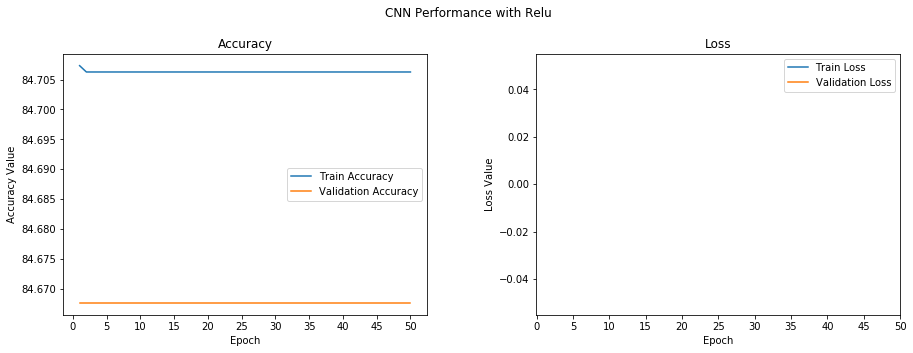

In [22]:
plot_accuracy_loss_CNN(hist2, title_fig = 'CNN Performance with Relu')
hist2

Test accuracy: 84.75329208313501


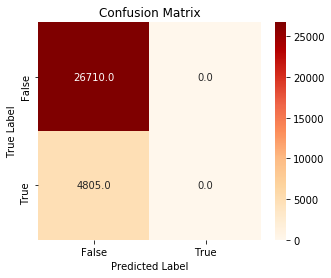

In [23]:
Display_prediction_results(network2, X_test, y_test)

# TRANSFER LEARNING

In [15]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [16]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [17]:
def plot_accuracy_loss(hist, title_fig = 'Pre-trained CNN (Transfer Learning) Performance'):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    t = f.suptitle(title_fig, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    n = len(hist.history['accuracy'])

    epoch_list = list(range(1,n+1))
    ax1.plot(epoch_list, hist.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, hist.history['val_accuracy'], label='Validation Accuracy')

    ax1.set_xticks(np.arange(0, n+1,5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, hist.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, n+1,5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

In [18]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [19]:
IMG_SIZE = 50
NUM_CLASSES = 2

X_train, X_test, X_val, y_train, y_test, y_val = pre_processing(img_size=IMG_SIZE, bgr = True)

describe_data_shape()

X_train shape: (94542, 50, 50, 3)
X_test shape: (31515, 50, 50, 3)
y_train shape: (94542, 2)
y_test shape: (31515, 2)
X_val shape: (31515, 50, 50, 3)
y val shape: (31515, 2)


In [20]:
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
input_tensor = img_augmentation(inputs)

In [21]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                ModelCheckpoint('model.hdf5',
                                 save_best_only=True)]

## VGG-16 MODEL

In [40]:
vgg = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor, classes=NUM_CLASSES)

vgg.trainable = True

vgg.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
img_augmentation (Sequential (None, 50, 50, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584

In [41]:
model = Sequential()
model.add(vgg)
model.add(layers.Flatten())
model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(Dense(2, activation='softmax', kernel_initializer='random_uniform', bias_initializer='random_uniform', bias_regularizer=regularizers.l2(0.01), name='predictions'))

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 4096)              2101248   
_________________________________________________________________
batch_normalization_6 (Batch (None, 4096)              16384     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                131104    
_________________________________________________________________
batch_normalization_7 (Batch (None, 32)               

In [42]:
%time
history=model.fit(X_train, y_train,validation_data=(X_val, y_val),verbose = 1,epochs = 50, batch_size=32)

CPU times: user 30 µs, sys: 0 ns, total: 30 µs
Wall time: 59.4 µs
Epoch 1/50
2955/2955 [==============================] - 103s 34ms/step - loss: 0.6024 - accuracy: 0.8064 - val_loss: 0.5172 - val_accuracy: 0.8905
Epoch 2/50
2955/2955 [==============================] - 99s 34ms/step - loss: 0.5326 - accuracy: 0.8606 - val_loss: 0.4231 - val_accuracy: 0.8974
Epoch 3/50
2955/2955 [==============================] - 100s 34ms/step - loss: 0.4815 - accuracy: 0.8765 - val_loss: 0.3615 - val_accuracy: 0.9094
Epoch 4/50
2955/2955 [==============================] - 100s 34ms/step - loss: 0.4356 - accuracy: 0.8887 - val_loss: 0.3116 - val_accuracy: 0.9122
Epoch 5/50
2955/2955 [==============================] - 100s 34ms/step - loss: 0.3980 - accuracy: 0.8953 - val_loss: 0.3154 - val_accuracy: 0.9115
Epoch 6/50
2955/2955 [==============================] - 100s 34ms/step - loss: 0.3628 - accuracy: 0.9004 - val_loss: 0.2988 - val_accuracy: 0.9136
Epoch 7/50
2955/2955 [==============================]

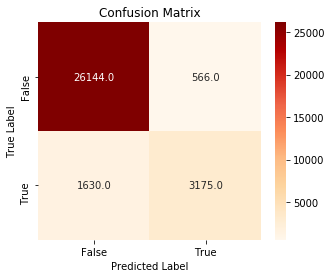

In [43]:
plot_confusion_matrix(model, X_test, y_test)

In [44]:
report(model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     26710
           1       0.85      0.66      0.74      4805

    accuracy                           0.93     31515
   macro avg       0.90      0.82      0.85     31515
weighted avg       0.93      0.93      0.93     31515



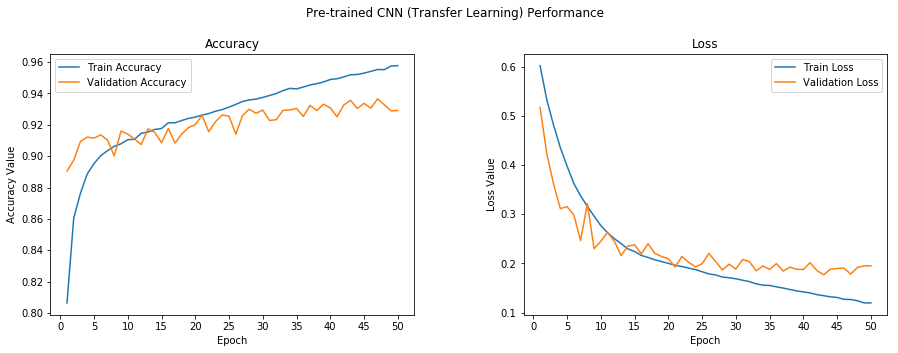

In [45]:
plot_accuracy_loss(history)

## RESNET-50

In [32]:
restnet = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor, pooling=None, classes=NUM_CLASSES)

restnet.trainable = True

restnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 50, 50, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 56, 56, 3)    0           img_augmentation[0][0]           
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 25, 25, 64)   9472        conv1_pad[0][0]                  
___________________________________________________________________________________________

In [35]:
import tensorflow as tf

model = Sequential()
model.add(restnet)
model.add(layers.Flatten())
model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(Dense(2, activation='softmax', kernel_initializer='random_uniform', bias_initializer='random_uniform', bias_regularizer=regularizers.l2(0.01), name='predictions'))

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              33558528  
_________________________________________________________________
batch_normalization_4 (Batch (None, 4096)              16384     
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                131104    
_________________________________________________________________
batch_normalization_5 (Batch (None, 32)               

In [36]:
%time
history = model.fit(X_train, y_train,validation_data=(X_val, y_val),verbose = 1,epochs = 50, batch_size=32)

CPU times: user 28 µs, sys: 0 ns, total: 28 µs
Wall time: 55.3 µs
Epoch 1/50
2955/2955 [==============================] - 186s 61ms/step - loss: 0.5974 - accuracy: 0.7938 - val_loss: 0.5284 - val_accuracy: 0.8565
Epoch 2/50
2955/2955 [==============================] - 177s 60ms/step - loss: 0.5220 - accuracy: 0.8670 - val_loss: 0.4905 - val_accuracy: 0.8868
Epoch 3/50
2955/2955 [==============================] - 175s 59ms/step - loss: 0.4688 - accuracy: 0.8858 - val_loss: 0.4119 - val_accuracy: 0.9053
Epoch 4/50
2955/2955 [==============================] - 179s 61ms/step - loss: 0.4241 - accuracy: 0.8964 - val_loss: 0.3554 - val_accuracy: 0.9129
Epoch 5/50
2955/2955 [==============================] - 176s 60ms/step - loss: 0.3895 - accuracy: 0.9024 - val_loss: 0.3408 - val_accuracy: 0.9139
Epoch 6/50
2955/2955 [==============================] - 178s 60ms/step - loss: 0.3600 - accuracy: 0.9060 - val_loss: 0.3543 - val_accuracy: 0.9144
Epoch 7/50
2955/2955 [==============================

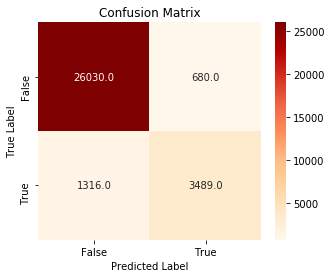

In [37]:
plot_confusion_matrix(model, X_test, y_test)

In [38]:
report(model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     26710
           1       0.84      0.73      0.78      4805

    accuracy                           0.94     31515
   macro avg       0.89      0.85      0.87     31515
weighted avg       0.93      0.94      0.93     31515



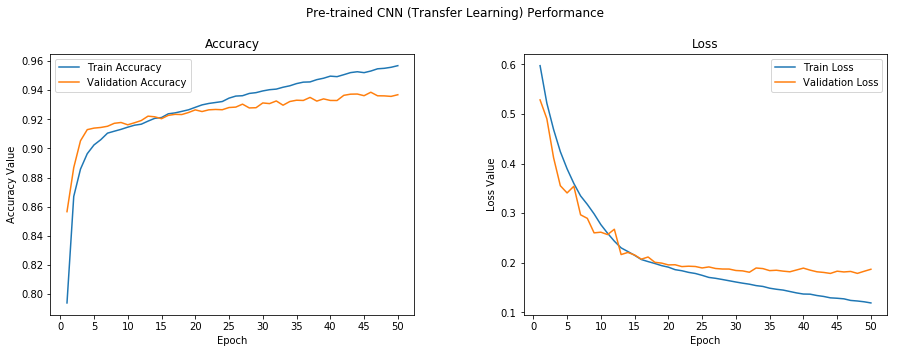

In [39]:
plot_accuracy_loss(history)

## Efficient Net

In [22]:
def build_model(num_classes):
#     inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
#     x = img_augmentation(inputs)
    model = EfficientNetB1(include_top=False, input_tensor=input_tensor, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = True

    # Rebuild top
    x = layers.Flatten()(model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(4096, activation='relu')(x)
    #top_dropout_rate = 0.2
    #x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='random_uniform', bias_regularizer=regularizers.l2(0.01), name='predictions')(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [23]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 50  # @param {type: "slider", min:8, max:80}
hist = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
2955/2955 [==============================] - 215s 69ms/step - loss: 0.4259 - accuracy: 0.8320 - val_loss: 0.4330 - val_accuracy: 0.8154
Epoch 2/50
2955/2955 [==============================] - 202s 68ms/step - loss: 0.3719 - accuracy: 0.8548 - val_loss: 0.3908 - val_accuracy: 0.8358
Epoch 3/50
2955/2955 [==============================] - 201s 68ms/step - loss: 0.3578 - accuracy: 0.8616 - val_loss: 0.4845 - val_accuracy: 0.7712
Epoch 4/50
2955/2955 [==============================] - 202s 68ms/step - loss: 0.3453 - accuracy: 0.8654 - val_loss: 0.3346 - val_accuracy: 0.8646
Epoch 5/50
2955/2955 [==============================] - 204s 69ms/step - loss: 0.3344 - accuracy: 0.8681 - val_loss: 0.3524 - val_accuracy: 0.8564
Epoch 6/50
2955/2955 [==============================] - 203s 69ms/step - loss: 0.3222 - accuracy: 0.8739 - val_loss: 0.3108 - val_accuracy: 0.8748
Epoch 7/50
2955/2955 [==============================] - 203s 69ms/step - loss: 0.3131 - accuracy: 0.8780 - val_loss: 0

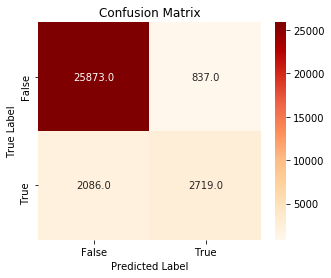

In [24]:
plot_confusion_matrix(model, X_test, y_test)

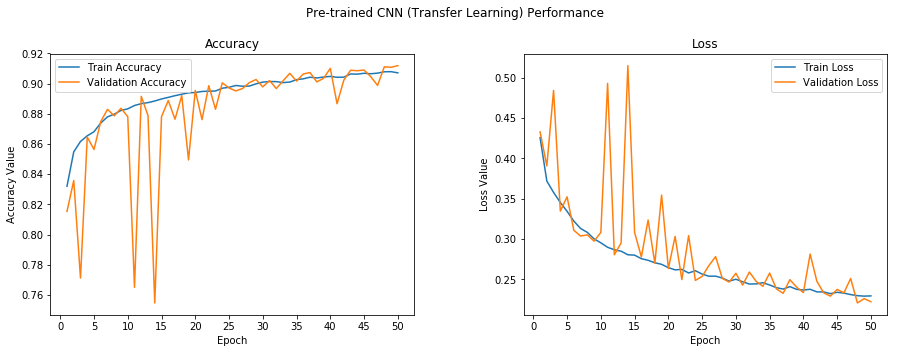

In [25]:
plot_accuracy_loss(hist)

In [26]:
report(model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     26710
           1       0.76      0.57      0.65      4805

    accuracy                           0.91     31515
   macro avg       0.85      0.77      0.80     31515
weighted avg       0.90      0.91      0.90     31515



In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 10  # @param {type: "slider", min:8, max:50}
hist = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=2)
plot_hist(hist)